In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import re
import csv
import sys
import json
import datetime
import requests
import difflib
RAW_DIR = "../raw/"
LIST_RAW_CSV = "../list_raw/all.csv"
LIST_RAW_JSON = "../transformed/all_json.json"
TRANSFORMED_DIR = "../transformed/"
OUTPUT = "output.txt"
GBTOUTPUT = "gbt.txt"
TITLEOUTPUT = "title.txt"

In [23]:
import citation-parser

SyntaxError: invalid syntax (<ipython-input-23-6a4d2588882f>, line 1)

In [18]:
#
full_keys = ["author","title","journal","year","DOI","month","citations(google scholar)","abstract","keywords","reference_count","ccfClass","important","references"]
full_keys_default = {"author":[],"title":"","journal":"","year":0,"DOI":"","month":0,"citations(google scholar)":-1,"abstract":"","keywords":[],"reference_count":0,"ccfClass":"","important":None,"references":[]}
# 常用函数定义
# 调用crossref接口
def string_similar(s1, s2):
    return difflib.SequenceMatcher(None, s1, s2).ratio()
def get_crossref_info(ref):
    url = "https://doi.crossref.org/servlet/query"

    querystring = {"usr":"halloweenwx@163.com","pwd":"halloween","format":"json","qdata":"""<?xml version = "1.0" encoding="UTF-8"?>
    <query_batch version="2.0" xmlns = "http://www.crossref.org/qschema/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
      <head>
          <email_address>hisham@atypon.com</email_address>
          <doi_batch_id>Sample multi resolve</doi_batch_id>
      </head>
      <body>
           <query key="mykey" enable-multiple-hits="true">
      <unstructured_citation>"""+ref+"""</unstructured_citation>
    </query>
         </body>
    </query_batch>"""}

    headers = {
        'User-Agent': "PostmanRuntime/7.20.1",
        'Accept': "*/*",
        'Cache-Control': "no-cache",
        'Postman-Token': "123bedd6-8fb9-43e5-980a-54336e7aa684,6312f073-8e24-4222-abb2-789899bbc01f",
        'Host': "doi.crossref.org",
        'Accept-Encoding': "gzip, deflate",
        'Connection': "keep-alive",
        'cache-control': "no-cache"
        }
    response = requests.request("GET", url, headers=headers, params=querystring)
#     print(response.text)
    return response.text

# 保存至transform
def save_tran_json(addr,jsonfile):
    with open(TRANSFORMED_DIR + addr, 'w') as o:
        o.write(json.dumps(jsonfile,ensure_ascii=False))
        
def save_tran_plain(addr,txtfile):
    with open(TRANSFORMED_DIR + addr, 'w') as o:
        o.write(txtfile)
        
def save_tran_lines(addr,txtfile):
    with open(TRANSFORMED_DIR + addr, 'a+') as o:
        for line in txtfile:
            o.write(line+'\n')    
# 从transformd中读取
def read_tran_json(addr):
    with open(TRANSFORMED_DIR + addr,encoding = 'utf-8') as f:
        data = json.load(f)
    return data
    
#  查询ccf等级
def search_ccf(s):
    ccf_all_addr = "/Users/Halloween/Desktop/Study/复杂网络/lrcns/raw-data/ccf/ccf_all.csv"

    ccf_all = []
    ccf_search_res = {}
    with open(ccf_all_addr,encoding = 'utf-8') as f:
        reader = csv.reader(f)
        for line in reader:
            ccf_all.append(line)
    level = ""
    field = ""
    cORj = ""
    col = -1
#     print(ccf_all)
    for line in reversed(ccf_all):
        if col != 1 and col != 2 and col != -1:
            col = -1
            continue
        if col == -1:
            for word in line[1:3]:
                if word == "":
                    continue
                if(string_similar(word,s)>0.9):
                    col = line.index(word)
                    ccf_search_res['ccf_search_res'] = word
#                     print('"'+word.strip('"')+'"'+'"'+s.strip('"')+'"')
#                     print(col)
#                     print(line)
                    break
        else:
            if len(line[0])>1 and line[0][1]=='、' and level == "":
                level = line[0][2]
#                 print(level)
            if len(line[0])>10 and line[0][:2]=="中国" and field == "":
                field = line[0][line[0].find("（")+1:line[0].find("）")]
                cORj = line[0][line[0].find("术")+1:line[0].find("（")]
#                 print(field)
    ccf_search_res.update({"level":level,"field":field,"type":cORj})
    return {"level":level,"field":field,"type":cORj}
# 数据审查函数
def inspect(to_inspect):
    papers_arr = to_inspect
    all_error = 0
    for paper in papers_arr:
        inspect = []
        for key in full_keys:
            if(key not in paper.keys() or type(paper[key]) != type(full_keys_default[key]) or paper[key] == full_keys_default[key]):
                inspect.append(key + " lost")
                continue
            if(key == "author" or key == "keywords" or key == "references"):
                if(type(paper[key]) != list or len(paper[key])==0):
                    inspect.append(key + " lost")
                    continue
            if(key == "year"):
                if(paper[key]<1900):
                    inspect.append(key + " error")
            if(key == "month"):
                if(paper[key]<0 or paper[key] >12):
                    inspect.append(key + " error")
            if(key == "citations(google scholar)" or key == "reference_count"):
                if(paper[key]<0):
                    inspect.append(key + " error")
            if(key == 'ccfClass'):
                if(paper[key] not in ['A','B','C']):
                    inspect.append(key + " error")
            if(type(paper[key])==int):
                if(paper[key]<0):
                    inspect.append(key + " less than 0")
                continue
            if(type(paper[key])==float):
                inspect.append(key + " not int")
                continue
        paper['inspect'] = list(inspect)
        print(paper['title']+str(paper['inspect']))
        all_error += len(paper['inspect'])
    print(">>>>SUMMARY ERRORs:"+str(all_error)+"<<<<<")
    return papers_arr

In [19]:
cleaned_arr = read_tran_json('y_clean.txt')


In [35]:
for paper in cleaned_arr:
    try:
        if(paper['DOI'][:2]=="10"):
            for ref in paper['references']:
                ref_doi = json.loads(ref['cross'])['created']['DOI']
                print(paper["DOI"]+";"+ref_doi)
    except:
        pass

10.1109/TMM.2012.2187436;10.1109/JPROC.2010.2044551
10.1109/TMM.2012.2187436;10.1023/B:VISI.0000013087.49260.fb
10.1109/TMM.2012.2187436;10.1109/ICCV.2007.4408858
10.1109/TMM.2012.2187436;10.1162/jocn.1991.3.1.71
10.1109/TMM.2012.2187436;10.1109/TNN.2002.804287
10.1109/TMM.2012.2187436;10.1109/34.598228
10.1109/ICPR.2014.735;10.1167/6.10.4
10.1109/ICPR.2014.735;10.1109/ICIP.2010.5652590
10.1109/ICPR.2014.735;10.1167/6.12.2
10.1109/TMM.2015.2461462;10.1109/TMM.2012.2231061
10.1109/TMM.2015.2461462;10.1109/TMM.2013.2267726
10.1109/TMM.2015.2461462;10.1109/TMM.2014.2329648
10.1109/TMM.2015.2461462;10.1109/TMM.2013.2264928
10.1109/TMM.2015.2461462;10.1109/TMM.2014.2315595
10.1109/TMM.2015.2461462;10.1007/978-3-642-15555-0_13
10.1109/TMM.2015.2461462;10.1007/978-3-319-05491-9_9
10.1109/TMM.2015.2461462;10.1145/2393347.2396297
10.1109/TMM.2015.2461462;10.1109/TMM.2014.2342658
10.1109/TMM.2015.2461462;10.1109/TIM.2012.2187468
10.1109/TPAMI.2018.2826549;10.1109/ICIP.2010.5652590
10.1109/TPAMI.

In [28]:
G = nx.Graph()
# for paper in cleaned_arr:
#     G.add_node(paper['DOI'])
#     for ref in paper['references']:
#         try:
#             ref_doi = json.loads(ref['cross'])['created']['DOI']
#             G.add_node(ref_doi)
#         except:
#             print("error")
            
            
G.list

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


AttributeError: 'Graph' object has no attribute 'list'

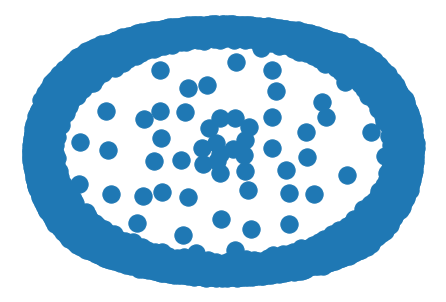

In [27]:
nx.draw(G)
plt.show()